In [62]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")


In [63]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nFirst few rows of training data:")
print(train_df.head())


Training data shape: (891, 12)
Test data shape: (418, 11)

First few rows of training data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0        

In [64]:
# Examine data info and missing values
print("=== TRAINING DATA INFO ===")
print(train_df.info())
print("\n=== MISSING VALUES IN TRAINING DATA ===")
print(train_df.isnull().sum())

print("\n=== TEST DATA INFO ===")
print(test_df.info())
print("\n=== MISSING VALUES IN TEST DATA ===")
print(test_df.isnull().sum())

print("\n=== SURVIVAL STATISTICS ===")
print(f"Survival rate: {train_df['Survived'].mean():.2%}")
print(train_df['Survived'].value_counts())


=== TRAINING DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

=== MISSING VALUES IN TRAINING DATA ===
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0


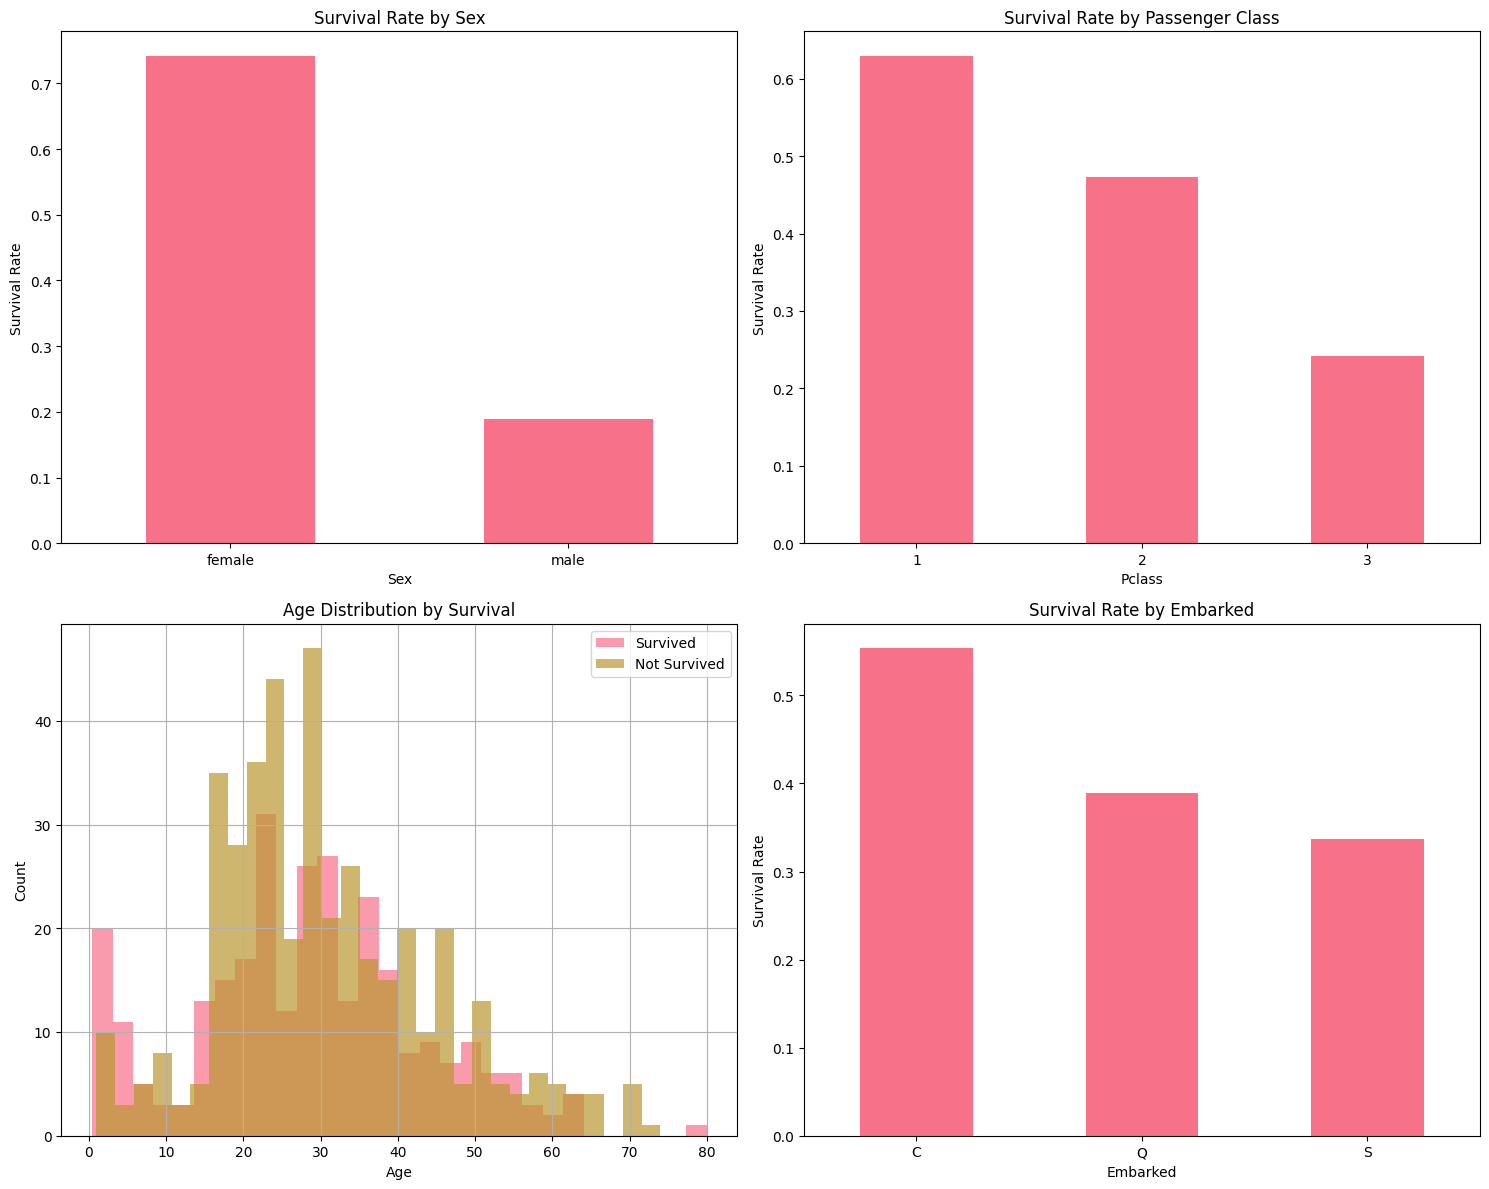

In [65]:
# Visualize survival by key features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Survival by Sex
train_df.groupby('Sex')['Survived'].mean().plot(kind='bar', ax=axes[0,0], title='Survival Rate by Sex')
axes[0,0].set_ylabel('Survival Rate')
axes[0,0].tick_params(axis='x', rotation=0)

# Survival by Passenger Class
train_df.groupby('Pclass')['Survived'].mean().plot(kind='bar', ax=axes[0,1], title='Survival Rate by Passenger Class')
axes[0,1].set_ylabel('Survival Rate')
axes[0,1].tick_params(axis='x', rotation=0)

# Age distribution by survival
train_df[train_df['Survived']==1]['Age'].hist(bins=30, alpha=0.7, label='Survived', ax=axes[1,0])
train_df[train_df['Survived']==0]['Age'].hist(bins=30, alpha=0.7, label='Not Survived', ax=axes[1,0])
axes[1,0].set_title('Age Distribution by Survival')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Count')
axes[1,0].legend()

# Survival by Embarked
train_df.groupby('Embarked')['Survived'].mean().plot(kind='bar', ax=axes[1,1], title='Survival Rate by Embarked')
axes[1,1].set_ylabel('Survival Rate')
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


In [66]:
# Combine train and test for consistent preprocessing
all_data = pd.concat([train_df, test_df], ignore_index=True, sort=False)

# Feature engineering function
def preprocess_data(df):
    # Create a copy
    data = df.copy()
    
    # 1. Handle missing values
    # Age: Fill with median by Pclass and Sex
    data['Age'] = data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
    
    # Embarked: Fill with mode
    data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
    
    # Fare: Fill with median by Pclass
    data['Fare'] = data.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    
    # 2. Feature Engineering
    # Family size
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
    # Is alone
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
    data['IsChild'] = (data['Age'] < 16).astype(int)
    data['IsWomanOrChild'] = (data['Sex'] == 'female') | (data['Age'] < 16).astype(int)
    
    # Extract title from name
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Group rare titles
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Miss', 'Lady': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
        'Capt': 'Rare', 'Sir': 'Rare'
    }
    data['Title'] = data['Title'].map(title_mapping).fillna('Rare')
    
    # Age groups
    data['AgeGroup'] = pd.cut(data['Age'], bins=[0, 12, 18, 35, 60, 100], 
                             labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # Fare groups
    data['FareGroup'] = pd.qcut(data['Fare'].fillna(data['Fare'].median()), q=4, 
                               labels=['Low', 'Medium', 'High', 'VeryHigh'])
    
    
    return data

# Apply preprocessing
processed_data = preprocess_data(all_data)
print("Preprocessing completed!")
print("Missing values after preprocessing:")
print(processed_data.isnull().sum())


Preprocessing completed!
Missing values after preprocessing:
PassengerId          0
Survived           418
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin             1014
Embarked             0
FamilySize           0
IsAlone              0
IsChild              0
IsWomanOrChild       0
Title                0
AgeGroup             0
FareGroup            0
dtype: int64


In [67]:
# Encode categorical variables and select features
def prepare_features(data):
    # Select features for modeling
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 
                'FamilySize', 'IsAlone', 'Title', 'AgeGroup', 'FareGroup',
                'IsChild', 'IsWomanOrChild']
    
    X = data[features].copy()
    
    # Encode categorical variables
    le = LabelEncoder()
    categorical_columns = ['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']
    
    for col in categorical_columns:
        X[col] = le.fit_transform(X[col].astype(str))
    
    return X

# Prepare features
X_all = prepare_features(processed_data)

# Split back into train and test
train_size = len(train_df)
X_train = X_all[:train_size]
X_test = X_all[train_size:]
y_train = train_df['Survived']

print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")

# Display feature correlation with survival
feature_importance = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print("\nFeature correlation with survival:")
print(feature_importance)


Training features shape: (891, 14)
Test features shape: (418, 14)
Training target shape: (891,)

Feature correlation with survival:
IsWomanOrChild    0.557080
Sex               0.543351
Pclass            0.338481
Fare              0.257307
IsAlone           0.203367
Embarked          0.167675
IsChild           0.136107
FareGroup         0.127907
Parch             0.081629
Title             0.071174
Age               0.058635
AgeGroup          0.048855
SibSp             0.035322
FamilySize        0.016639
dtype: float64


In [68]:
# Split training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Train and evaluate models
model_scores = {}
trained_models = {}

print("Model Performance (Cross-Validation):")
print("=" * 50)

for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    model_scores[name] = cv_scores.mean()
    
    # Train on full training set
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Validation score
    val_pred = model.predict(X_val_split)
    val_accuracy = accuracy_score(y_val_split, val_pred)
    
    print(f"{name}:")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")
    print()

# Select best model
best_model_name = max(model_scores, key=model_scores.get)
best_model = trained_models[best_model_name]

print(f"Best Model: {best_model_name} with CV score: {model_scores[best_model_name]:.4f}")


Model Performance (Cross-Validation):
Random Forest:
  CV Score: 0.8047 (+/- 0.0543)
  Validation Accuracy: 0.9888

Gradient Boosting:
  CV Score: 0.8283 (+/- 0.0400)
  Validation Accuracy: 0.9106

Logistic Regression:
  CV Score: 0.8227 (+/- 0.0374)
  Validation Accuracy: 0.8380

Best Model: Gradient Boosting with CV score: 0.8283


Performing hyperparameter tuning for Random Forest...
Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest CV score: 0.8350

Top 10 Feature Importances:
           feature  importance
13  IsWomanOrChild    0.175183
5             Fare    0.160346
1              Sex    0.154000
2              Age    0.121490
0           Pclass    0.091931
9            Title    0.083940
7       FamilySize    0.058190
11       FareGroup    0.039783
3            SibSp    0.031341
6         Embarked    0.025170


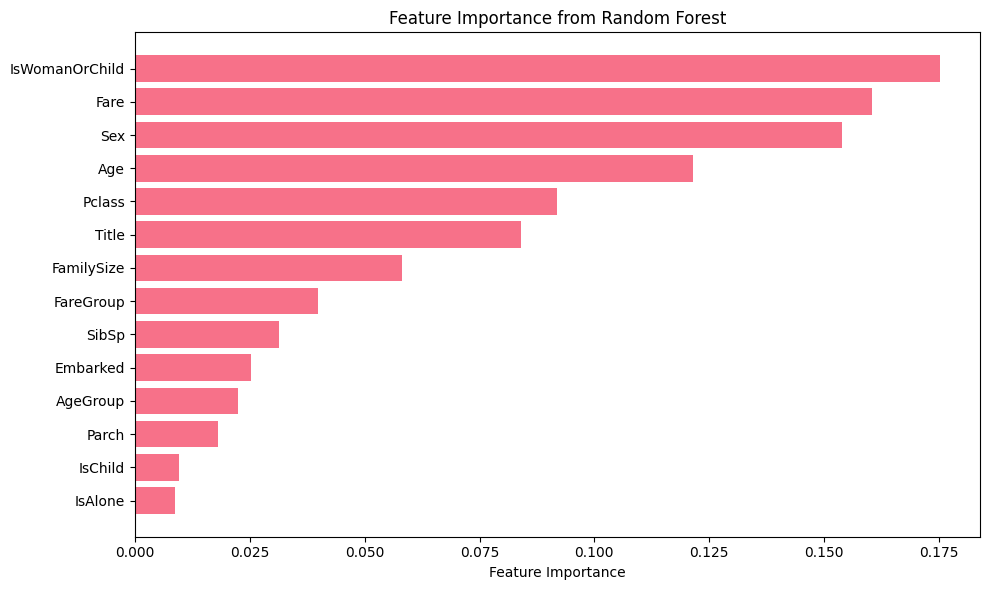

In [69]:
# Hyperparameter tuning for Random Forest (typically performs well on this dataset)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Performing hyperparameter tuning for Random Forest...")
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best Random Forest CV score: {rf_grid.best_score_:.4f}")

# Feature importance analysis
if hasattr(best_rf, 'feature_importances_'):
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Feature Importances:")
    print(importance_df.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importance_df)), importance_df['importance'])
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance from Random Forest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [70]:
# ENSEMBLE: Combine predictions from all trained models
from sklearn.ensemble import VotingClassifier

# Create ensemble from your existing trained models
ensemble = VotingClassifier([
    ('rf', best_rf),
    ('gb', trained_models['Gradient Boosting']),
    ('lr', trained_models['Logistic Regression'])
], voting='soft')

# Fit ensemble
ensemble.fit(X_train, y_train)
test_predictions = ensemble.predict(X_test)

# Create submission dataframe
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

print("Prediction distribution:")
print(submission['Survived'].value_counts())
print(f"Predicted survival rate: {submission['Survived'].mean():.2%}")

# Save submission file
submission.to_csv('titanic_submission.csv', index=False)
print("\nSubmission file 'titanic_submission.csv' created successfully!")

# Display first few predictions
print("\nFirst 10 predictions:")
print(submission.head(10))


Prediction distribution:
Survived
0    275
1    143
Name: count, dtype: int64
Predicted survival rate: 34.21%

Submission file 'titanic_submission.csv' created successfully!

First 10 predictions:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
5          897         0
6          898         0
7          899         0
8          900         1
9          901         0
